# Classifier Task

### Hi, run all cells and enjoy the analysis.
Explanation on what the code does and why I wrote it comes before the code, and the findings are written after/below the outputs.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning) # for more readable code
plt.rcParams["figure.figsize"] = (15,10)
%matplotlib inline

# Exploratory analysis and feature engineering

I have been given a dataset without context with the sole goal to create a model to predict the boolean `target` variable. Let's have a look at the data:

In [2]:
data = pd.read_csv('data_science_assignment_data.csv', parse_dates=['date'])
data.head(5)

,date,numeric0,numeric1,categorical0,time,target
0,2015-11-24,2515,2.0,c,01:33:52,0
1,2009-03-05,5156,NaN,b,20:09:27,0
2,2015-12-23,5930,NaN,b,11:22:35,0
3,1992-02-16,2967,NaN,b,19:18:36,0
4,1971-06-06,194,5.0,c,20:01:58,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          10000 non-null  datetime64[ns]
 1   numeric0      10000 non-null  int64         
 2   numeric1      5083 non-null   float64       
 3   categorical0  10000 non-null  object        
 4   time          10000 non-null  object        
 5   target        10000 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 468.9+ KB


It seems we have a date, two numeric, a categorical and a time variable. The `target` variable is boolean. We are missing around half of the observations for the `numeric1` variable.

Next, I create new features from the `date` and `time` features to be able to explore their distribution and correlation coefficients

In [4]:
clean_data = data.copy()
clean_data['year'] = clean_data['date'].dt.year
clean_data['month'] = clean_data['date'].dt.month
clean_data['day'] = clean_data['date'].dt.day
clean_data['hour'] = [int(x[:2]) for x in clean_data.time]
clean_data['minute'] = [int(x[3:5]) for x in clean_data.time]
clean_data['second'] = [int(x[6:]) for x in clean_data.time]
clean_data['weekday'] = clean_data['date'].dt.weekday

clean_data = clean_data.drop(['date', 'time'], axis=1)

Print a sample of the data:

In [5]:
clean_data.head()

,numeric0,numeric1,categorical0,target,year,month,day,hour,minute,second,weekday
0,2515,2.0,c,0,2015,11,24,1,33,52,1
1,5156,NaN,b,0,2009,3,5,20,9,27,3
2,5930,NaN,b,0,2015,12,23,11,22,35,2
3,2967,NaN,b,0,1992,2,16,19,18,36,6
4,194,5.0,c,0,1971,6,6,20,1,58,6


As we can see, each time unit is now represented as its own feature and `weekday` is presented as new feature.
Next, I proceed to analyse the statistics and distributions of the features.

In [6]:
clean_data.describe()

,numeric0,numeric1,target,year,month,day,hour,minute,second,weekday
count,10000.000000,5083.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4981.998600,4.540035,0.133000,1994.251800,6.479500,15.787300,11.302900,29.489700,29.671400,2.983600
std,2886.313858,2.863159,0.339592,14.213022,3.408217,8.783995,6.944017,17.219813,17.301756,2.010009
min,0.000000,0.000000,0.000000,1970.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2499.750000,2.000000,0.000000,1982.000000,4.000000,8.000000,5.000000,15.000000,15.000000,1.000000
50%,4940.500000,5.000000,0.000000,1994.000000,6.000000,16.000000,11.000000,29.000000,30.000000,3.000000
75%,7487.250000,7.000000,0.000000,2006.000000,9.000000,23.000000,17.000000,44.000000,45.000000,5.000000
max,9999.000000,9.000000,1.000000,2019.000000,12.000000,31.000000,23.000000,59.000000,59.000000,6.000000


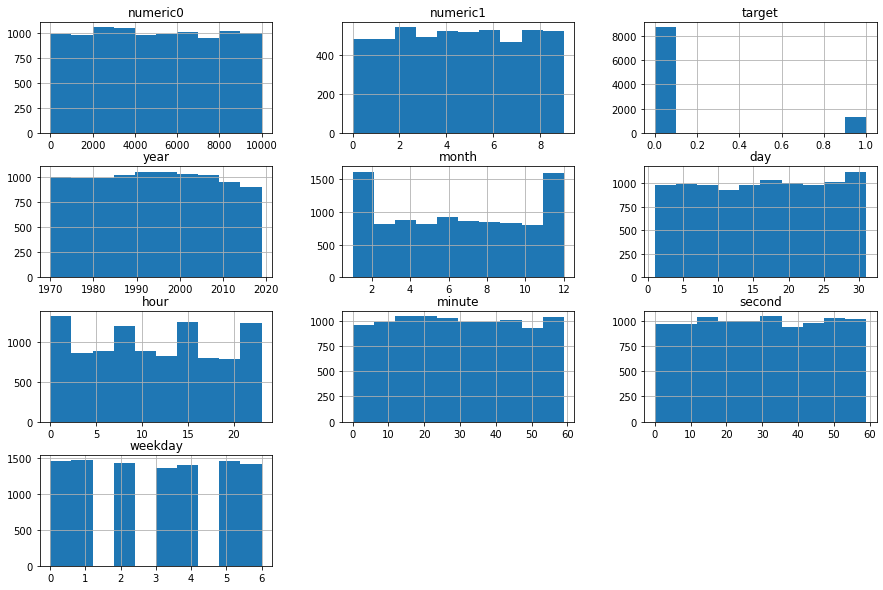

In [7]:
plt.rcParams["figure.figsize"] = (15,10)
clean_data.hist(layout=(4,3));

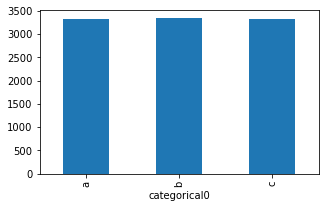

In [8]:
plt.rcParams["figure.figsize"] = (5,3)
clean_data.groupby(data['categorical0'])['categorical0'].count().plot(kind='bar');

It seems most of our features are in uniform distribution. The distribution of the `target` variable is unbalanced which has to be taken into account when training and evaluating the models. Let's see how much of `target` class are positive:

In [9]:
print(f'{clean_data.target.sum()/clean_data.target.shape[0]} of the observations are from positive target class')

0.133 of the observations are from positive target class


Next, I one-hot-encode the `categorical0` feature, so I'm only dealing with numerical data and able to compute correlations across the matrix

In [10]:
clean_data = pd.get_dummies(clean_data, prefix="cat0", columns=['categorical0'])

Let's see what the Pearson correlation coefficients between the features are. Correlation with the `target` variable suggests that feature can be useful as a predictor at least with linear models. High correlation with other features suggests feature collinearity, which we would like to eliminate before training the model.

<AxesSubplot:>

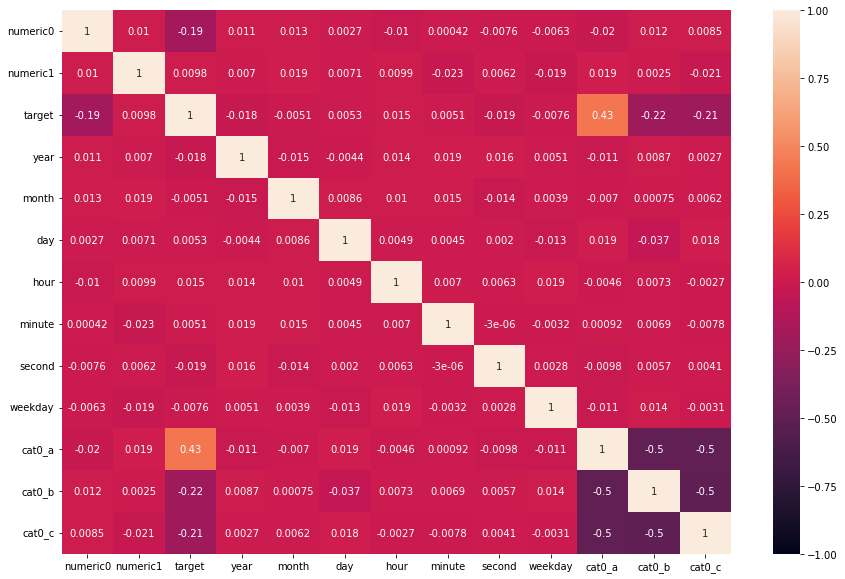

In [11]:
plt.rcParams["figure.figsize"] = (15,10)
sns.heatmap(clean_data.corr(), vmin=-1, vmax=1, annot=True)

We learn some things from the correlations. Firstly, the `categorical0` and `numeric0` features have some correlation with the target. We also learn that none of the variables correlate with numeric1, which is an indication not to try to predict the missing values from the other features.

Let's see if the "Nan" value of `numeric1` is meaningful information by engineering a new feature `numeric1_is_nan` with a boolean value. Because our algorithms cannot handle missing data and better solutions have not emerged, let's impute the missing values with the feature's mean value.

In [12]:
clean_data['numeric1_is_nan'] = [1 if math.isnan(x) == True else 0 for x in clean_data['numeric1']]
numeric1_mean = clean_data['numeric1'].mean()
clean_data['numeric1']  = [numeric1_mean if math.isnan(x) == True else x for x in clean_data['numeric1']]

Let's look at the correlations again

<AxesSubplot:>

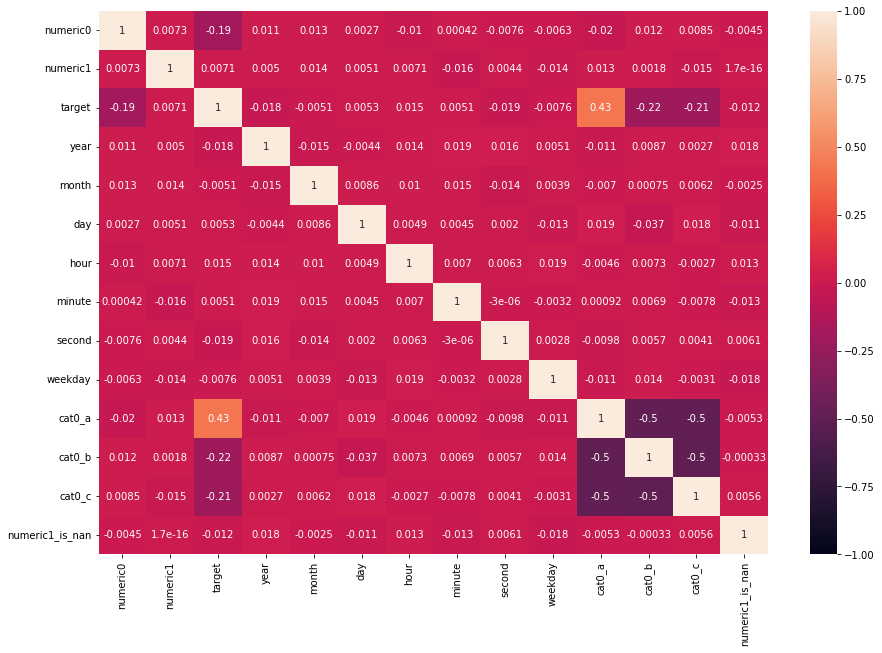

In [13]:
plt.rcParams["figure.figsize"] = (15,10)
sns.heatmap(clean_data.corr(), vmin=-1, vmax=1, annot=True)

No luck there - imputing didn't improve the correlation, and the new feature `numeric1_is_nan` doesn't show correlation with the target feature.

Moving on, the `categorical0` has some correlation I want to dig deeper into. Let's have a look how the positive values are distributed along this feature by computing the number of ones in each category.

In [14]:
data.groupby('categorical0')['target'].sum()

categorical0
a    1124
b      97
c     109
Name: target, dtype: int64

__Mamma mia!__ Our minority class is heavily correlated to the category "a". This is a pattern a classifier will certainly learn, but we need to make sure it is not the only factor in the decision. This takes to us to the end of the exploratory analysis phase.

# Data preparation and feature selection

Correlation coefficients are more important in feature selection for linear models, but more complex non-linear models can learn patterns from combinations of several features. 

__At this point, I have to select a classifier algorithm for the task. I will start with Gradient Boosted Decision Trees -algorithm from scikit-learn library for in my experience it has been a very versatile classifier for different tasks.__

I will next perform feature selection by training a Gradient Boosted Decision Trees -algorithm and computing its feature importance -metrics.

First, I need to normalize the data, so that the different scales of the features don't throw off the classifier algorithms.

In [15]:
scaler = MinMaxScaler()
feature_columns = [x for x in clean_data.columns if x != "target" ]
clean_data[feature_columns] = scaler.fit_transform(clean_data[feature_columns])
clean_data.describe()

,numeric0,numeric1,target,year,month,day,hour,minute,second,weekday,cat0_a,cat0_b,cat0_c,numeric1_is_nan
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.498250,0.504448,0.133000,0.494935,0.498136,0.492910,0.491430,0.499825,0.502905,0.497267,0.332400,0.334100,0.333500,0.491700
std,0.288660,0.226799,0.339592,0.290062,0.309838,0.292800,0.301914,0.291861,0.293250,0.335001,0.471097,0.471698,0.471487,0.499956
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.444444,0.000000,0.244898,0.272727,0.233333,0.217391,0.254237,0.254237,0.166667,0.000000,0.000000,0.000000,0.000000
50%,0.494099,0.504448,0.000000,0.489796,0.454545,0.500000,0.478261,0.491525,0.508475,0.500000,0.000000,0.000000,0.000000,0.000000
75%,0.748800,0.555556,0.000000,0.734694,0.727273,0.733333,0.739130,0.745763,0.762712,0.833333,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As we can see, the features are now scaled down to range from 0 to 1 instead of original varying scales.

The target feature is heavily unbalanced in our dataset. I will address this by limiting the number of observations for the majority class in the training set by creating a new sample including all the positive samples and randomly picking negative samples so that the dataset used in modeling has positive and negative samples with the ratio of 1:2 (ratio found through experimenting with different ratios)


In [16]:
# sample all positive observations
all_positive_samples = clean_data[clean_data.target == 1]
# multiplier for negative sample (how many times the positive samples
negative_sample_multiplier = 2
# number of positive observations
number_positive_samples = all_positive_samples.shape[0]
# number of negative observations to sample
number_of_negative_samples = number_positive_samples * negative_sample_multiplier
# sample multiplier times
limited_negative_samples = clean_data[clean_data.target == 0].sample(number_of_negative_samples, random_state=123)
balanced_dataset = pd.concat([all_positive_samples, limited_negative_samples], ignore_index=True)

Next, I will create the train and test datasets from the balanced dataset so that the ratio of positive and negative classes is equal in both samples so that the hold-out test set is comparable to the distribution of the original dataset. I will hold-out 0.2 of the balanced data set for evaluation purposes.

In [17]:
y = balanced_dataset[['target']]
X = balanced_dataset.drop(columns='target')

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=1337)
for train, test in sss.split(X,y): 
    X_train= X.iloc[train]
    y_train = y.iloc[train]
    X_test = X.iloc[test]
    y_test = y.iloc[test]


To be able to compare my models efficiently, I define a function that fits a model on the training data and prints the cross-validated Balanced Accuracy Score metric with the feature importance graph.

__I chose Balanced Accuracy score as the validation and evaluation metric because I want a balanced model that is optimized for predicting both of the classes as correctly as possible.__

In [18]:
def fit_cv_model(algorithm, X_train, y_train, cv_folds=3):
    #Fit the algorithm on the data
    features = X_train.columns
    algorithm.fit(X_train, y_train)
        
    #Predict training set:
    train_predictions = algorithm.predict(X_train)
    
    #Perform cross-validation:
    cv_score = cross_val_score(algorithm, X_train, y_train, cv=cv_folds, scoring='balanced_accuracy')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy (Train): %.4g" % metrics.accuracy_score(y_train.values, train_predictions))
    print("Balanced Accuracy score(Train): %f" % metrics.balanced_accuracy_score(y_train, train_predictions))
    print(f'Mean Balanced Accuracy score (CV) : {np.mean(cv_score)} | Std - {np.std(cv_score)}')
        
    #Print Feature Importance:
    feat_imp = pd.Series(algorithm.feature_importances_, features).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

I will first train a baseline GradientBoostingClassifier model for feature selection with default parameters.


Model Report
Accuracy (Train): 0.8618
Balanced Accuracy score(Train): 0.867011
Mean Balanced Accuracy score (CV) : 0.7467064582731715 | Std - 0.006468378957218444


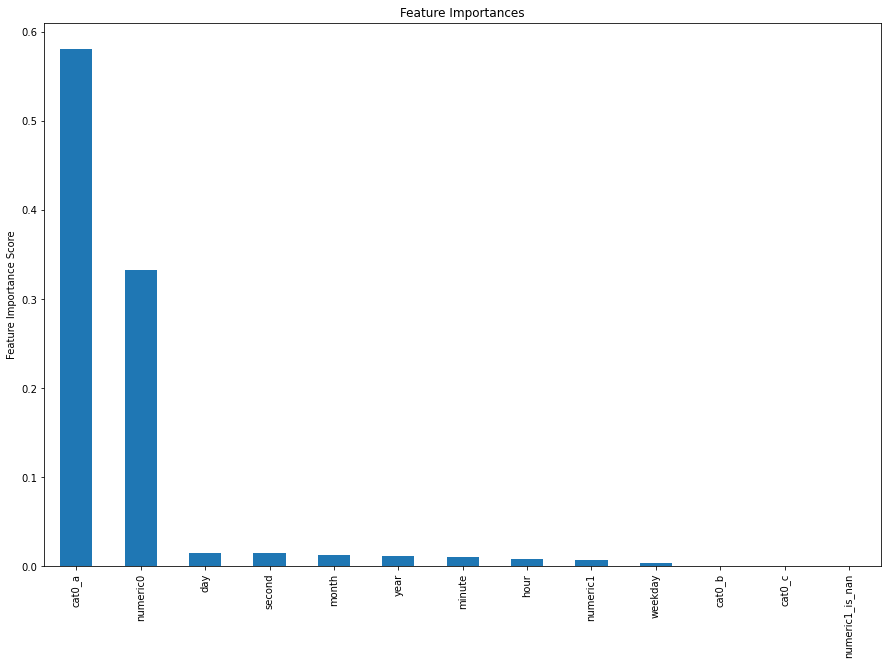

In [19]:
gbc_baseline = GradientBoostingClassifier(random_state=1337)
fit_cv_model(gbc_baseline, X_train, y_train)

Feature importance metric tells how much the features influenced the classification decision on this particular model and is not universal truth for the data. Let's see if a model trained with same parameters and just the two "important" features `cat0_a` and `numeric0` does any better.


Model Report
Accuracy (Train): 0.8261
Balanced Accuracy score(Train): 0.846100
Mean Balanced Accuracy score (CV) : 0.7692489871589642 | Std - 0.009216555646709632


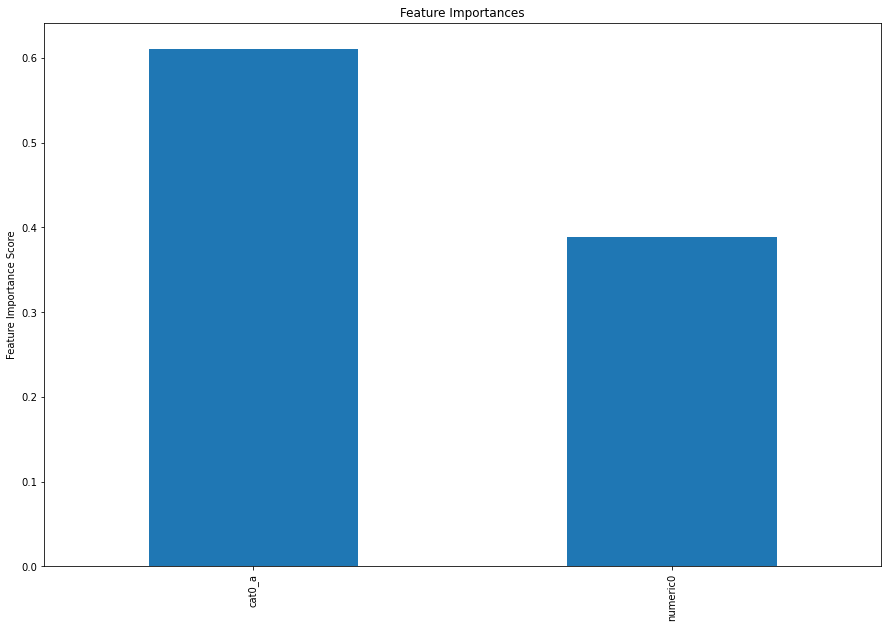

In [20]:
gbc_baseline_selected_features = GradientBoostingClassifier(random_state=1337)
fit_cv_model(gbc_baseline, X_train[['cat0_a', 'numeric0']], y_train)

Our Balanced Accuracy score (CV) went up from 0.747 to 0.769 which indicates that we are able to make more robust model by removing the unimportant features. Let's just leave cat0_a and numeric0 as the predictor features in our training and test sets

In [21]:
X_train = X_train[['cat0_a', 'numeric0']]
X_test = X_test[['cat0_a', 'numeric0']]

# Model selection and hyper parameter tuning

I will next perform hyper parameter optimization for the model.

Optimization is performed by grid search method:
1. Train and cross-validate baseline model with starting parameters.
2. Create a parameter grid for parameters A and cross-validate models for all given value combinations in the grid.
3. Take the parameter values from the best performing model and use them in the next round of testing with a grid of new parameters.
4. Repeat step 3 until all wanted parameters have been optimized.
5. Analyse how validation score has developed compared to the baseline model.

I will optimize:
    'n_estimators',
    'learning_rate',
    'max_depth',
    'min_samples_split',
    'min_samples_leaf',
    'max_features'
parameters for balanced accuracy score metric.

Our baseline was model `gbc_baseline_selected_features` with balanced accuracy score of 0.769

The next cells are commented out because the optimization takes several minutes and who has several minutes these days.

Round 1:  `n_estimators` and `learning_rate` parameters

In [22]:
# param_test1 = {'n_estimators':[500,1000,1500], 'learning_rate':[0.1, 0.05, 0.01]}
# gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(random_state=1337), 
# param_grid = param_test1, scoring='balanced_accuracy',n_jobs=4, cv=3)
# gsearch1.fit(X_train, y_train)
# print(gsearch1.best_params_)

Round 2: `max_depth` and `min_samples_split` parameters

In [23]:
# param_test2 = {'max_depth':range(3,10,2), 'min_samples_split':range(100,500,100)}
# gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(**gsearch1.best_params_, random_state=1337),
# param_grid = param_test2, scoring='balanced_accuracy',n_jobs=4, cv=3)
# gsearch2.fit(X_train, y_train);
# print(gsearch2.best_params_)

Round 3: `min_samples_leaf` and `max_features` parameters

In [24]:
# param_test3 = {'min_samples_leaf':range(20,61,10), 'max_features':['auto', 'sqrt', 'log2']}
# gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(**gsearch1.best_params_, **gsearch2.best_params_, random_state=1337),
# param_grid = param_test3, scoring='balanced_accuracy',n_jobs=4, cv=3)
# gsearch3.fit(X_train, y_train);
# print(gsearch3.best_params_)

Round 4: learning parameters `n_estimators` and `learning_rate` again

In [25]:
# param_test4 = {'n_estimators':range(500,1500,100), 'learning_rate':[0.1, 0.05, 0.01]}
# gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(**gsearch2.best_params_, **gsearch3.best_params_, random_state=1337),
# param_grid = param_test4, scoring='balanced_accuracy',n_jobs=4, cv=3)
# gsearch4.fit(X_train, y_train);
# print(gsearch4.best_params_)

In [26]:
# Hard coded parameters after running the grid search rounds
optimized_params = {'learning_rate': 0.01, 'n_estimators': 500, 'max_depth': 3, 'min_samples_split': 200, 'min_samples_leaf': 40, 'max_features':'sqrt'}
optimized_params

{'learning_rate': 0.01,
 'n_estimators': 500,
 'max_depth': 3,
 'min_samples_split': 200,
 'min_samples_leaf': 40,
 'max_features': 'sqrt'}

We now have the best parameters found though grid search optimization. Let's see how our optimized model performs with the training data


Model Report
Accuracy (Train): 0.8004
Balanced Accuracy score(Train): 0.823073
Mean Balanced Accuracy score (CV) : 0.7868649146358312 | Std - 0.005805411314430168


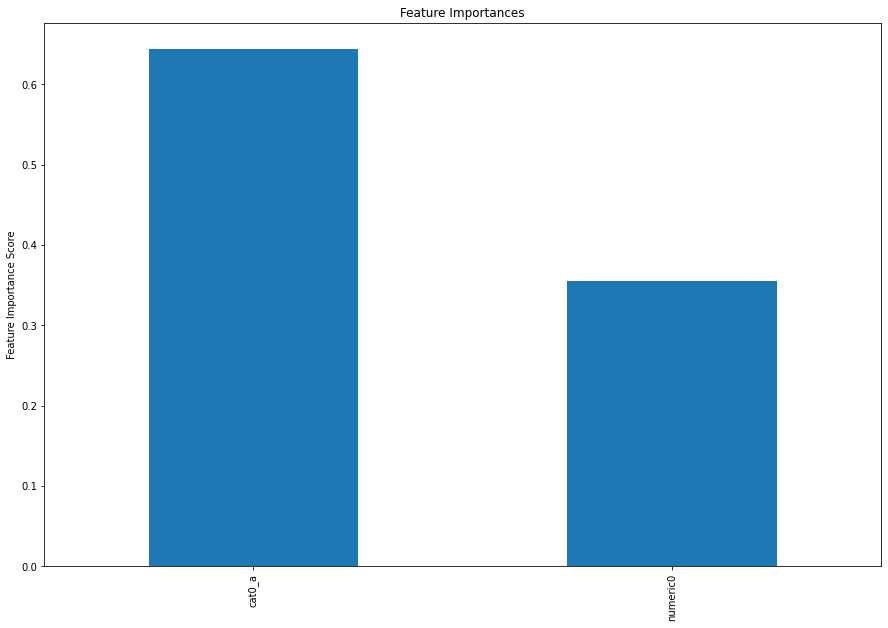

In [27]:
gbc1 = GradientBoostingClassifier(**optimized_params, random_state=1337)
fit_cv_model(gbc1, X_train, y_train)

__Our training accuracy was 0.800 and cross-validated balanced accuracy score went up from 0.769 to 0.787. Parameter optimization has improved our model, at least with the training data.__

# Model evaluation

__In model evaluation I am using the Balanced Accuracy Score metric, which was also used in validating.__

Let's see how our optimized model `gbc1` performs on the test data. First I define a function to train and evaluate models with.

In [28]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    # fit the model on train data
    model.fit(X_train, y_train)
    # make predictions on test set
    predictions = model.predict(X_test)
    # compute confusion matrix metrics
    cm = confusion_matrix(y_test, predictions)
    tn = cm[0][0]
    fn = cm[1][0]
    tp = cm[1][1]
    fp = cm[0][1]

    # print metrics and confusiom matrix
    print(f'Balanced accuracy score {metrics.balanced_accuracy_score(y_test, predictions)}')
    print(f'True positive rate is: {tp/(tp+fn)}')
    print(f'True negative rate is: {tn/(tn+fp)}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot() 

### Evaluation of model `gbc1`:

Balanced accuracy score 0.7922932330827068
True positive rate is: 0.8383458646616542
True negative rate is: 0.7462406015037594


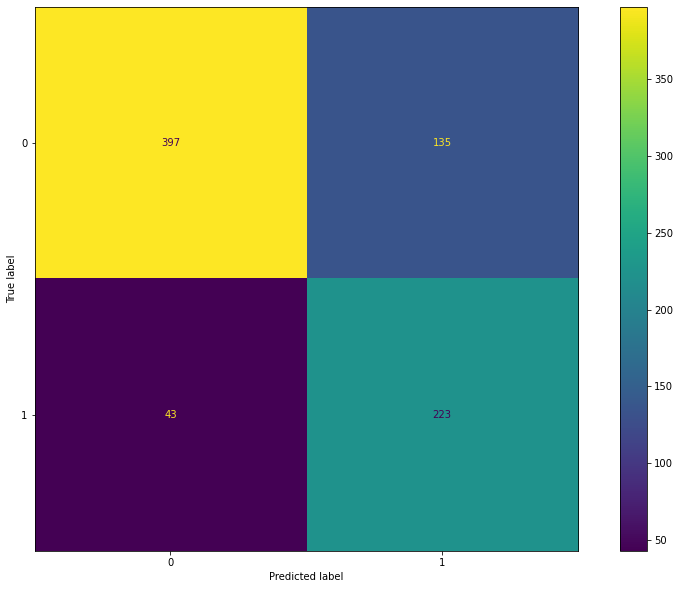

In [29]:
train_and_evaluate(gbc1, X_train, y_train, X_test, y_test)

Our model performs even better with the test set with balanced accuracy score of 0.792, which means our model is not over fit. Our model got 84% of the positive label and 75% of the negative class correct.

## Experiment on different class ratios in training data

Let's experiment by training Gradient Boosted Classifiers with same parameters but training with (1:1) or more (3:1) ratio of negative to positive samples. We have to resample and make new train and test sets for each model.

### Evaluation of model `gbc2` - less negative samples (1:1)

Balanced accuracy score 0.8439849624060151
True positive rate is: 0.9887218045112782
True negative rate is: 0.6992481203007519


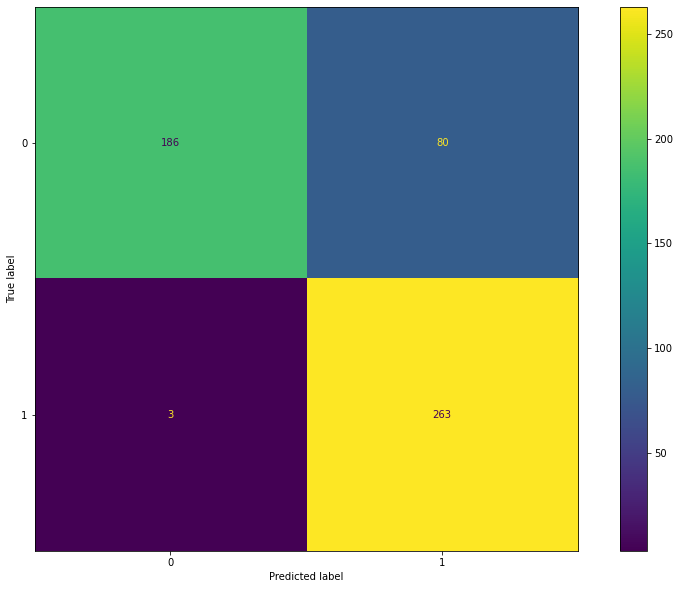

In [30]:
# RESAMPLE THE DATA
# sample all positive observations
all_positive_samples = clean_data[clean_data.target == 1]
# multiplier for negative sample (how many times the positive samples
negative_sample_multiplier = 1
# number of positive observations
number_positive_samples = all_positive_samples.shape[0]
# number of negative observations to sample
number_of_negative_samples = number_positive_samples * negative_sample_multiplier
# sample multiplier times
limited_negative_samples = clean_data[clean_data.target == 0].sample(number_of_negative_samples, random_state=123)
balanced_dataset = pd.concat([all_positive_samples, limited_negative_samples], ignore_index=True)

y = balanced_dataset[['target']]
X = balanced_dataset[['cat0_a', 'numeric0']]

# SPLIT THE RESAMPLED DATA
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=1337)
for train, test in sss.split(X,y): 
    X_train= X.iloc[train]
    y_train = y.iloc[train]
    X_test = X.iloc[test]
    y_test = y.iloc[test]

# Train and evaluate the new model
gbc2 = GradientBoostingClassifier(**optimized_params, random_state=1337)
train_and_evaluate(gbc2, X_train, y_train, X_test, y_test)

By further limiting the number of negative samples in the training data, we can get a model that predicts almost all (99%) positive labels correctly with the setback that only 70% of the negative label are correct. This might be a more favorable outcome, depending on the context of the task. The balanced accuracy score was also improved to 0.844.


Let's try if adding negative samples has the opposite effect

### Evaluation of model `gbc3` - more negative samples (3:1)

Balanced accuracy score 0.6384711779448622
True positive rate is: 0.3233082706766917
True negative rate is: 0.9536340852130326


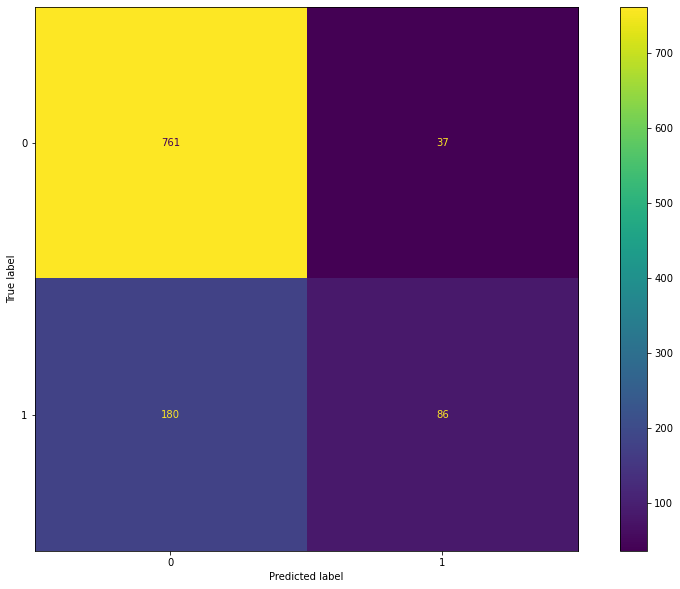

In [31]:
# RESAMPLE THE DATA
# sample all positive observations
all_positive_samples = clean_data[clean_data.target == 1]
# multiplier for negative sample (how many times the positive samples
negative_sample_multiplier = 3
# number of positive observations 
number_positive_samples = all_positive_samples.shape[0]
# number of negative observations to sample
number_of_negative_samples = number_positive_samples * negative_sample_multiplier
# sample multiplier times
limited_negative_samples = clean_data[clean_data.target == 0].sample(number_of_negative_samples, random_state=123)
balanced_dataset = pd.concat([all_positive_samples, limited_negative_samples], ignore_index=True)

y = balanced_dataset[['target']]
X = balanced_dataset[['cat0_a', 'numeric0']]

# SPLIT THE RESAMPLED DATA
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=1337)
for train, test in sss.split(X,y):
    X_train= X.iloc[train]
    y_train = y.iloc[train]
    X_test = X.iloc[test]
    y_test = y.iloc[test]

# Train and evaluate the new model
gbc3 = GradientBoostingClassifier(**optimized_params, random_state=1337)
train_and_evaluate(gbc3, X_train, y_train, X_test, y_test)

Indeed, our overall balanced accuracy dropped to 0.638 as we get 95% of the negative label, but only 32% of the positive label right.

__Without a clear goal, it is difficult to say which one is the best performing model, but based on balanced accuracy score it would be model `gbc2` with score of 0.844. This model was trained with data that had 1:1 ratio of positive and negative samples and was very good at predicting the positive class correctly__

The scores aren't actually fully comparable as they are evaluated with different datasets. The point of this experiment was to show that different outcomes can be reached when the classification objective and context is known.

# Conclusion

Task was to train a binary classifier on a data without context and without a set goal metric. I performed:
1. exploratory analysis on the data to find the distributions and correlations of the features
2. some feature engineering to make more use of the data - unsuccessfully
3. feature selection based on pearson correlation efficients and Gradient Boosted Classifier feature importance metrics
4. parameter optimization with grid search and cross validation
5. model evaluation on balanced accuracy score metric and by analyzing the confluence matrix
6. experimentation on different ratios of minority and majority classes present in the training data

__I was able to get the balanced accuracy score up to 0.844 and found that I can optimize the accuracy for either of the classes by tuning the amount of negative class present in the training data, but and compromising on the accuracy on the other class.__